# Amazon Alexa Review - Sentiment Analysis 

Amazon Alexa is a popular voice-controlled virtual assistant developed by Amazon, and its associated devices like Echo speakers have garnered a significant number of reviews on Amazon's website. The goal of this project is to extract these reviews, apply sentiment analysis using machine learning and NLP to understand the sentiments expressed by customers, and potentially gain insights into customer satisfaction or dissatisfaction with Alexa devices.

# Data 
> The original data came from: 
https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews

# Key features 

1. Rating = rating value (between 1 and 5) given by the user 
2. Date = the date the review was posted
3. Variation = type of amazon alexa product
4. Verified reviews = the textual review given by the user for a variation of the product
5. Feedback = feedback of the verified review. 
    * 0 - negative feedback 
    * 1 - positive feedback 

# Preparing the tools 

In [1]:
# Import all the tools we need 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import mpld3
import plotly.express as px
from IPython.display import SVG, display
import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


# We want our plots to appear inside the notebook 
%matplotlib inline 

import warnings 
warnings.filterwarnings('ignore')

# Machine learning 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split 


# Save the model 
import joblib 
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the data 


In [2]:
df = pd.read_csv("amazon_alexa.tsv", delimiter = '\t', quoting= 3)
print(f"Dataset shape: {df.shape}")
df

Dataset shape: (3150, 5)


rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  
0                                         Love my Echo!         1  
1                                             Loved it!         1  
2     "Sometimes while playing a game, you can answe...         1  
3     "I have had a lot of fun with this thing. My 4...         1  
4                                                 Music         1  
...                                                 ...       ...  
3145  "Perfect for kids, adults and everyone in betw...         1  
3146  "Listening to music, searching locations, chec...         1  
3147  "I do love these things, i have them running m...         1  
3148  "Only complaint I have is that the sound quali...         1  
3149                                               Good         1  

[3150 rows x 5 columns]

# Exploratory Data Analysis 
In this phase, our focus will be on exploring the dataset. We'll carefully examine the data, searching for any gaps or missing information. We'll then proceed to analyze the data statistically, aiming to uncover patterns and trends within it. Additionally, we'll utilize visualizations to present the data in a more understandable format. This approach will enable us to gain insights into the structure of the data, identify any notable patterns, and gain a better understanding of the relationships between different variables.

In [3]:
df.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  "Sometimes while playing a game, you can answe...         1  
3  "I have had a lot of fun with this thing. My 4...         1  
4                                              Music         1

In [4]:
df.tail()

rating       date   variation  \
3145       5  30-Jul-18  Black  Dot   
3146       5  30-Jul-18  Black  Dot   
3147       5  30-Jul-18  Black  Dot   
3148       5  30-Jul-18  White  Dot   
3149       4  29-Jul-18  Black  Dot   

                                       verified_reviews  feedback  
3145  "Perfect for kids, adults and everyone in betw...         1  
3146  "Listening to music, searching locations, chec...         1  
3147  "I do love these things, i have them running m...         1  
3148  "Only complaint I have is that the sound quali...         1  
3149                                               Good         1

In [5]:
# Display the data types of each column 
print(df.dtypes)

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object


* rating and feedback are integer values 
* date, variation and verfied_reviews are string values

In [6]:
# Statistical analysis 
df.describe()

rating     feedback
count  3150.000000  3150.000000
mean      4.463175     0.918413
std       1.068506     0.273778
min       1.000000     0.000000
25%       4.000000     1.000000
50%       5.000000     1.000000
75%       5.000000     1.000000
max       5.000000     1.000000

In [7]:
# Column names 
print(f"Feature names : {df.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [8]:
# Check for missing values 
missing_values = df.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

Missing values in each column:
rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


In [9]:
# Getting the record where 'verified_reviews' is null 
df[df['verified_reviews'].isna() == True]

rating       date variation verified_reviews  feedback
473       2  29-Jun-18     White              NaN         0

In [10]:
# Drop the column with the null record since it's only one 
df.dropna(inplace=True)
print(f"Dataset shape after dropping null values: {df.shape}")

Dataset shape after dropping null values: (3149, 5)


In [11]:
# Creating a new column 'Lenght' that contains the length of the string in 'verified_reviews' column 
df['length'] = df['verified_reviews'].apply(len)

In [12]:
# Check the new column 'Length'
df.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  length  
0                                      Love my Echo!         1      13  
1                                          Loved it!         1       9  
2  "Sometimes while playing a game, you can answe...         1     197  
3  "I have had a lot of fun with this thing. My 4...         1     174  
4                                              Music         1       5

### Rating column analysis 


In [13]:
# Let's finf the distinct values of 'rating' and its count  

print(f"Rating value count:\n{df['rating'].value_counts()}")

Rating value count:
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


In [14]:
# Let's create a plot 
df = pd.DataFrame(df)

fig = px.histogram(df, x='rating', title='Rating Distribution Count', 
                   labels={'rating': 'Ratings', 'count': 'Count'},
                   color_discrete_sequence=['coral'])

fig.show()

In [15]:
# Let's find the percentage distribution of each rating - we'll divide the number of records for each rating by the total number of records

print(f"Rating value count - percentage distribution:\n{round(df['rating'].value_counts()/df.shape[0]*100,2)}")

Rating value count - percentage distribution:
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


In [16]:
# Let's create a plot 

df = pd.DataFrame(df)

rating_counts = df['rating'].value_counts()
percentage_distribution = round(rating_counts / df.shape[0] * 100, 2)

fig = px.pie(names=percentage_distribution.index, values=percentage_distribution.values,
             title='Rating Distribution (%)')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

* Both of the graphs reveal a notable trend towards higher ratings, with the majority of users assigning a rating of 5. This dominance of the highest rating suggests that a significant portion of users are highly satisfied with the product.

### Feedback column analysis 

In [17]:
# Distinct values of 'feedback' and its count 
print(f"Rating value count:\n{df['feedback'].value_counts()}")

Rating value count:
feedback
1    2893
0     256
Name: count, dtype: int64


We have 2 different values of 'feedback', 0 and 1. 

##### Feedback value 0

In [18]:
# Extracting the 'verified_reviews' value for on record with feedback = 0

review_0 = df[df['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [19]:
# Extracting the 'verified_reviews' value for on record with feedback = 1

review_1 = df[df['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


Based on the information above, we can see that feedback `0` is a `negative review` and `1` is a `positive review` 

In [20]:
# Let's create a plot to visualize the total counts of each feedback 

data = {
    'feedback': df['feedback'].astype('category')
}

df_feedback = pd.DataFrame(data)

feedback_counts = df_feedback['feedback'].value_counts().reset_index()
feedback_counts.columns = ['Feedback', 'Count']  
fig = px.bar(feedback_counts, x='Feedback', y='Count', 
             title='Feedback Distribution Count', 
             labels={'Feedback': 'Feedback', 'Count': 'Count'},
             color='Feedback', color_discrete_sequence=['orange', 'limegreen'])

fig.update_layout(xaxis={'type': 'category', 'categoryarray': ['0', '1']})
fig.show()

In [21]:
# Let's find the percentage distribution of each feedback - we'll divide the number of records for each feedback by the total number of records
print(f"Feedback value count - percentage distribution: \n{round(df['feedback'].value_counts()/df.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


In [22]:
# Let's create a plot 

data = {
    'feedback': [1, 0],
    'percentage': [91.87, 8.13]
}

df_percentage = pd.DataFrame(data)

fig = px.pie(df_percentage, values='percentage', names='feedback', 
             title='Feedback Distribution (%)',
             hole=0.4,  
             color_discrete_sequence=["gold", "tomato"]) 

fig.show()

Feedback distribution: 
* 2893 that represents the 91.9% of the total reviews, are positive 
* 256 that represents the 8.13% of the total reviews, are negative

Overall, users are satisfied with the product as we saw also in the rating graphs.

#### Rating values vs Feedback values

In [23]:
# Feedback = 0 
df[df['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [24]:
# Feedback = 1
df[df['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

**If the rating of a review is 1 or 2 the feedback is 0 (negative), and if the rating of a review is 3, 4 or 5 then the feedback is 1 (positive)**

### Variation column analysis 

In [25]:
# Let's distinct values of 'variation' and its count 

print(f"Variation value caunt: \n{df['variation'].value_counts()}")

Variation value caunt: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


In [26]:
#Let's create a plot 

data = {'variation': df['variation']}
df_variation = pd.DataFrame(data)


variation_counts = df_variation['variation'].value_counts().reset_index()
variation_counts.columns = ['Variation', 'Count']

fig = px.scatter(variation_counts, x='Variation', y='Count', size='Count',
                 title='Variation Distribution Counts',
                 labels={'Variation': 'Variation', 'Count': 'Count'},
                 hover_name='Variation', size_max=30,
                color='Count', color_continuous_scale='Viridis',  
                 template='plotly_white')

fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(xaxis_tickangle=-45)

fig.show()

In [27]:
# Fiding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records 
print(f"Variation value count - percentage distribution: \n{round(df['variation'].value_counts()/df.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [45]:
# Let's create a plot 

variation_counts = df['variation'].value_counts()

percentage_distribution = round(variation_counts / df.shape[0] * 100, 2)

df_percentage = pd.DataFrame({'Variation': percentage_distribution.index,
                              'Percentage': percentage_distribution.values})

fig = px.bar(df_percentage, x='Variation', y='Percentage',
              title='Variation Distribution (%)', color="Percentage")

fig.update_layout(xaxis_title='Variation', yaxis_title='Percentage (%)',xaxis_tickangle=-45, barmode='stack')
fig.show()

* We can see that users prefer the Black Dot and their least favorite is the Walnut Finish, this can be due to different reasons such as difference in price and affordability, availability and market trends.

### Verified reviews column analysis

We are going to use the `length` column since it's the numeric representation of the `verified_reviews` column

In [29]:
df['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

##### Length analysis when feedback is 0 - negative

In [72]:
# Let's create a plot 

filtered_df = df[df['feedback'] == 0]

length_counts = filtered_df['length'].value_counts().sort_index()

df_length_counts = pd.DataFrame({'Review Length': length_counts.index,
                                 'Count': length_counts.values})

fig = px.histogram(df_length_counts, x='Review Length', y='Count',
              title='Distribution of Review Length when Feedback is 0',
              labels={'Review Length': 'Review Length', 'Count': 'Count'},
              template='plotly_white',
              color_discrete_sequence=['orchid'])

fig.update_layout(xaxis_title='Review Length', yaxis_title='Count')
fig.show()

##### Length analysis when feedback is 1 - positive

In [74]:
# Let's create a plot

filtered_df = df[df['feedback'] == 1]

length_counts = filtered_df['length'].value_counts().sort_index()

df_length_counts = pd.DataFrame({'Review Length': length_counts.index,
                                 'Count': length_counts.values})

fig = px.histogram(df_length_counts, x='Review Length', y='Count',
              title='Distribution of Review Length when Feedback is 1',
              labels={'Review Length': 'Review Length', 'Count': 'Count'},
              template='plotly_white',
              color_discrete_sequence=['orange'])

fig.update_layout(xaxis_title='Review Length', yaxis_title='Count')
fig.show()

In both cases, when the feedback is 0 (negative) and 1 (positive), the length of the reviews are on the shorter side meaning that the users don't have the tendency to write long reviews.

##### Lengthwise mean rating 

In [76]:
# Let's create a plot 

mean_ratings_by_length = df.groupby('length')['rating'].mean().reset_index()

fig = px.scatter(mean_ratings_by_length, x='length', y='rating',
              title='Review Lengthwise Mean Ratings',
              labels={'length': 'Review Length', 'rating': 'Mean Rating'},
              template='plotly_white',
              color_discrete_sequence=['darkturquoise'])

fig.update_layout(xaxis_title='Review Length', yaxis_title='Mean Rating')
fig.show()

The mean lenght is high for positive feedback, customers who are satisfied with a product often want to share their positive experiences with others. They may include specific details, anecdotes, or use cases to highlight why they enjoyed the product.

In [59]:
# We are going to use CountVectorizer to take the textual data and convert it into vector representations
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

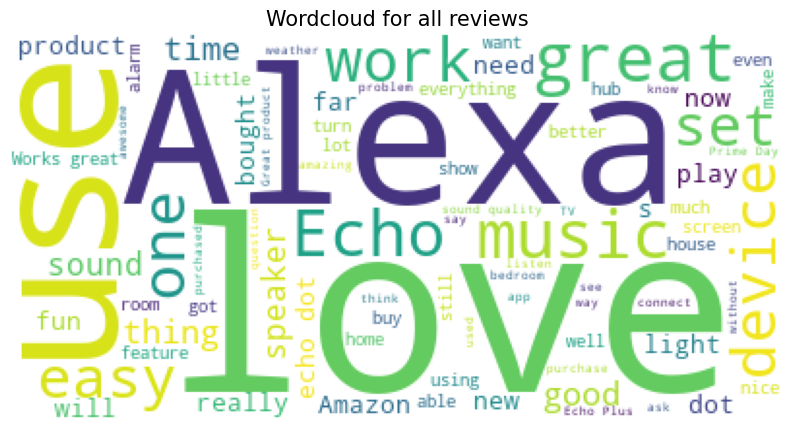

In [84]:
# We want to combine all reviews 
reviews = " ".join([review for review in df['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=80)

# Generate and plot wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=15)
plt.axis('off');

#### Diving the data into positive and negative feedback

In [81]:
# Combine all reviews for each feedback category and split them into individual words
neg_reviews = " ".join([review for review in df[df['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Finding words from reviews present in that feedback category only 
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

###### Negative feedback

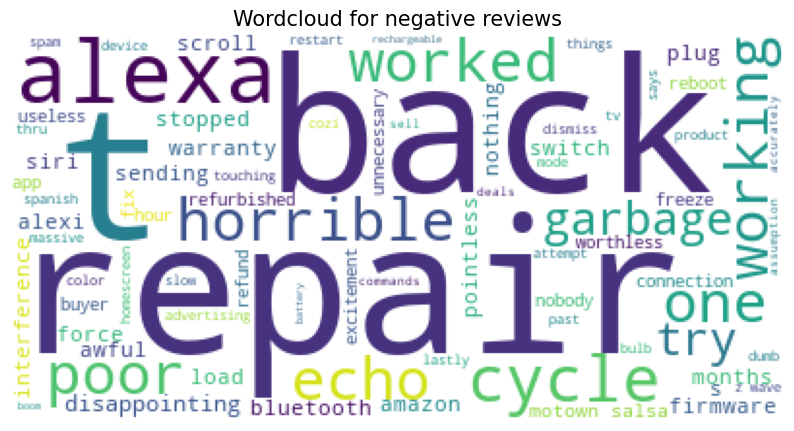

In [83]:
wc = WordCloud(background_color = 'white', max_words=80)

# Generate and plot wordcloud 
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=15)
plt.axis('off');

###### Positive feedback

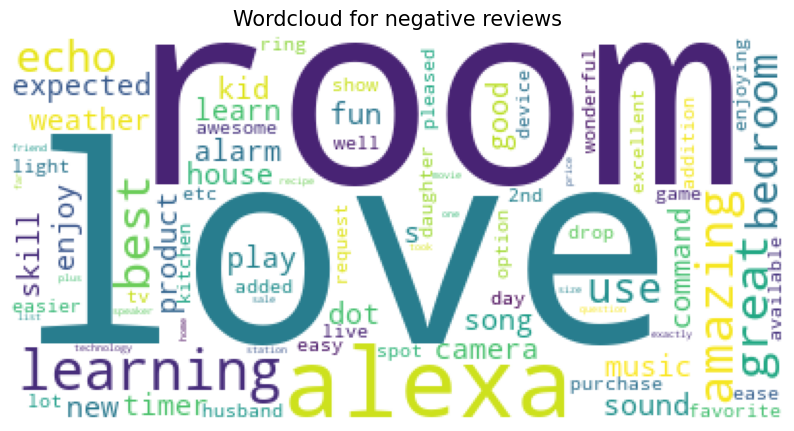

In [85]:
wc = WordCloud(background_color = 'white', max_words=80)

# Generate and plot wordcloud 
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for negative reviews', fontsize=15)
plt.axis('off');

# Preprocessing

To build the corpus from the `verified_reviews` we are going to do the following: 

1. Replace any non alphabet characters with a space 
2. Convert to lower case and split into words 
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus 